In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /home/ira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2023-12-07 10:17:07.863082: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 10:17:07.864174: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-07 10:17:07.885924: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-07 10:17:07.886378: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
df1 = pd.read_csv('completeSpamAssassin.csv', delimiter=',')
df2 = pd.read_csv('emailsStudyMartOwner.csv', delimiter=',')
df3 = pd.read_csv('enronSpamSubset.csv', delimiter=',')
df4 = pd.read_csv('spam_ham_datasetYashpal.csv', delimiter=',')

# Data Preprocessing
### Consolidating the Datasets

In [3]:
print(df1)

      Unnamed: 0                                               Body  Label
0              0  \nSave up to 70% on Life Insurance.\nWhy Spend...      1
1              1  1) Fight The Risk of Cancer!\nhttp://www.adcli...      1
2              2  1) Fight The Risk of Cancer!\nhttp://www.adcli...      1
3              3  ##############################################...      1
4              4  I thought you might like these:\n1) Slim Down ...      1
...          ...                                                ...    ...
6041        6041                                              empty      0
6042        6042                    ___           ___           ...      0
6043        6043  IN THIS ISSUE:01. Readers write\n02. Extension...      0
6044        6044                                              empty      0
6045        6045                                              empty      0

[6046 rows x 3 columns]


In [4]:
df1 = df1.drop(df1.columns[0], axis=1)
df1.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [5]:
print(df2)

                                                   text spam Unnamed: 2  \
0     Subject: naturally irresistible your corporate...    1        NaN   
1     Subject: the stock trading gunslinger  fanny i...    1        NaN   
2     Subject: unbelievable new homes made easy  im ...    1        NaN   
3     Subject: 4 color printing special  request add...    1        NaN   
4     Subject: do not have money , get software cds ...    1        NaN   
...                                                 ...  ...        ...   
5725  Subject: re : research and development charges...    0        NaN   
5726  Subject: re : receipts from visit  jim ,  than...    0        NaN   
5727  Subject: re : enron case study update  wow ! a...    0        NaN   
5728  Subject: re : interest  david ,  please , call...    0        NaN   
5729  Subject: news : aurora 5 . 2 update  aurora ve...    0        NaN   

     Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8  \
0           NaN        Na

In [6]:
df2 = df2.iloc[:, :2]
df2 = df2.rename(columns={'text': 'Body', 'spam': 'Label'})
df2.head()

,Body,Label
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [7]:
print(df3)

      Unnamed: 0.1  Unnamed: 0  \
0             2469        2469   
1             5063        5063   
2            12564       12564   
3             2796        2796   
4             1468        1468   
...            ...         ...   
9995         26222       26222   
9996         18630       18630   
9997         18451       18451   
9998         21955       21955   
9999         32062       32062   

                                                   Body  Label  
0     Subject: stock promo mover : cwtd\n * * * urge...      1  
1     Subject: are you listed in major search engine...      1  
2     Subject: important information thu , 30 jun 20...      1  
3     Subject: = ? utf - 8 ? q ? bask your life with...      1  
4     Subject: " bidstogo " is places to go , things...      1  
...                                                 ...    ...  
9995  Subject: monday 22 nd oct\n louise ,\n do you ...      0  
9996  Subject: missing bloomberg deals\n stephanie -...      0  
9997  

In [8]:
df3 = df3.drop(df3.columns[[0, 1]], axis=1)
df3.head()

,Body,Label
0,Subject: stock promo mover : cwtd\n * * * urge...,1
1,Subject: are you listed in major search engine...,1
2,"Subject: important information thu , 30 jun 20...",1
3,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,"Subject: "" bidstogo "" is places to go , things...",1


In [9]:
print(df4)

      Unnamed: 0 label                                               text  \
0            605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1           2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2           3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3           4685  spam  Subject: photoshop , windows , office . cheap ...   
4           2030   ham  Subject: re : indian springs\r\nthis deal is t...   
...          ...   ...                                                ...   
5166        1518   ham  Subject: put the 10 on the ft\r\nthe transport...   
5167         404   ham  Subject: 3 / 4 / 2000 and following noms\r\nhp...   
5168        2933   ham  Subject: calpine daily gas nomination\r\n>\r\n...   
5169        1409   ham  Subject: industrial worksheets for august 2000...   
5170        4807  spam  Subject: important online banking alert\r\ndea...   

      label_num  
0             0  
1             0  
2             0  
3  

In [10]:
df4 = df4.drop(df4.columns[[0, 1]], axis=1)
df4 = df4.rename(columns={'text': 'Body', 'label_num': 'Label'})
df4.head()

,Body,Label
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [11]:
df = pd.concat([df1, df2.iloc[:, :], df3.iloc[:, :], df4.iloc[:, :]], ignore_index=True)
print(df)

                                                    Body Label
0      \nSave up to 70% on Life Insurance.\nWhy Spend...     1
1      1) Fight The Risk of Cancer!\nhttp://www.adcli...     1
2      1) Fight The Risk of Cancer!\nhttp://www.adcli...     1
3      ##############################################...     1
4      I thought you might like these:\n1) Slim Down ...     1
...                                                  ...   ...
26942  Subject: put the 10 on the ft\r\nthe transport...     0
26943  Subject: 3 / 4 / 2000 and following noms\r\nhp...     0
26944  Subject: calpine daily gas nomination\r\n>\r\n...     0
26945  Subject: industrial worksheets for august 2000...     0
26946  Subject: important online banking alert\r\ndea...     1

[26947 rows x 2 columns]


### Cleaning up the Entries

In [12]:
# making sure all labels are in the same format
df['Label'] = pd.to_numeric(df['Label'], errors='coerce')
df = df.dropna(subset=['Label'])
df['Label'] = df['Label'].astype(int)

# Removing 'noise' from the texts
df['Body'] = df['Body'].astype(str)
df['Body'] = df['Body'].str.lower()
df['Body'] = df['Body'].str.replace('^subject: ', '', regex=True)
df['Body'] = df['Body'].str.replace('\n', ' ',)
df['Body'] = df['Body'].str.replace('\r', ' ',)
df['Body'] = df['Body'].str.replace('^re:', '',)
df['Body'] = df['Body'].str.replace('^re :', '', regex=True)
df['Body'] = df['Body'].str.replace(' re :', '')
df['Body'] = df['Body'].str.replace('^fw:', '',)
df['Body'] = df['Body'].str.replace('^fw :', '', regex=True)
df['Body'] = df['Body'].str.replace(' fw :', '')
df['Body'] = df['Body'].str.replace('^url:', '', regex=True)
# removing URL's
df['Body'] = df['Body'].str.replace(r'(http[s]?://|www\.)\S+', '', regex=True)
# removing email addresses
df['Body'] = df['Body'].str.replace(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', regex=True)

# removing non alphanumeric and non-punctuation characters
df['Body'] = df['Body'].str.replace(r'[^a-z0-9,.:;\'`\-?!()&]', ' ', regex=True)
# removing extra spaces
df['Body'] = df['Body'].str.replace(r'\s+', ' ', regex=True)
df['Body'] = df['Body'].str.replace('^ ', '', regex=True)

### Removing Unnecessary Entries

In [13]:
df = df.drop_duplicates()

# creating a copy of the dataframe with only alphanumeric characters
df_plain = df
df_plain['Body'] = df_plain['Body'].str.replace(r'[^a-z0-9]', ' ', regex=True)
df_plain['Body'] = df_plain['Body'].str.replace(r'\s+', ' ', regex=True)

def is_subset_of_other_email(email, email_series):
    for other_email in email_series:
        if email != other_email and email in other_email:
            return True
    return False

mask = df_plain['Body'].apply(lambda x: not is_subset_of_other_email(x, df_plain['Body']))
#Use the mask to filter the DataFrame
df = df[mask]

In [14]:
# removing entries with no text
df = df[df['Body'] != 'empty']
df = df[df['Body'] != '']
df = df.dropna(subset=['Body'])
df = df.reset_index(drop=True)

df.shape

(20472, 2)

### Spam to Ham Numbers and Proportions

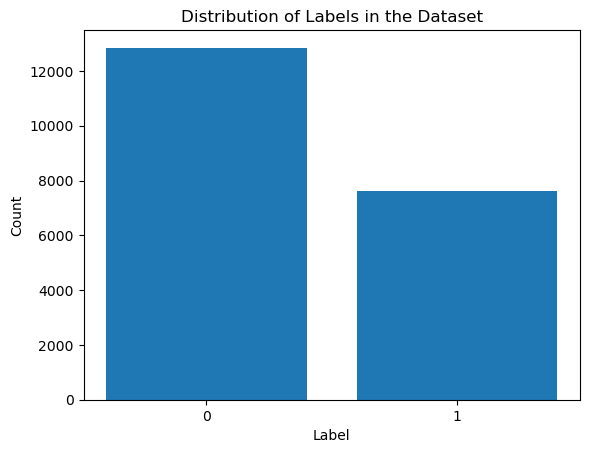

In [15]:
label_counts = df['Label'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in the Dataset')
plt.xticks([0, 1])  # Set x-ticks to be the labels
plt.show()

In [16]:
spam_counts = df['Label'].value_counts()
spam_percent = df['Label'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
print(pd.concat([spam_counts, spam_percent], axis=1, keys=['Counts', 'Percentage']))

       Counts Percentage
Label                   
0       12849     62.76%
1        7623     37.24%


In [17]:
# shuffling the entries
df = df.sample(frac=1).reset_index(drop=True)
df.shape

(20472, 2)

In [18]:
print(df)

                                                    Body  Label
0      also available levitra cialis and viagra keepi...      1
1      calpine monthly nomination forwarded by aimee ...      0
2      john p looney wrote on thu aug 22 2002 at 05 1...      0
3       no subject stinson henwood can help us with t...      0
4      lose 19 weight new weightloss available to you...      1
...                                                  ...    ...
20467  now i know bundle famish welcome varou the gra...      1
20468  new line item f y i japanese electricity is th...      0
20469  new turn on range resources vance a ticket has...      0
20470  use perl daily headline mailerspouses afternoo...      0
20471  powerisk 2001 your invitation angelika thanks ...      0

[20472 rows x 2 columns]


# Further Preparations
### Vectorizing the Texts

In [19]:
# preprocessing the data
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(txt):
    tokens = word_tokenize(txt)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and t.isalnum()]
    return tokens

df['Preproc_txt'] = df['Body'].apply(preprocess)

# creating tagged data
tagged_data = [TaggedDocument(words=txt, tags=[i]) for i, txt in enumerate(df['Preproc_txt'])]

# training a Doc2Vec model
model = Doc2Vec(vector_size=50, window=3, min_count=1, workers=4, epochs=200, dm=0)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# converting text data to vectors
df['Vector'] = df['Preproc_txt'].apply(lambda x: model.infer_vector(x))
df.head(10)

,Body,Label,Preproc_txt,Vector
0,also available levitra cialis and viagra keepi...,1,"[also, available, levitra, cialis, viagra, kee...","[1.6163436, 2.1998005, 0.84823847, -0.9715893,..."
1,calpine monthly nomination forwarded by aimee ...,0,"[calpine, monthly, nomination, forwarded, aime...","[1.0151408, 0.62459177, 0.26562575, -1.0730993..."
2,john p looney wrote on thu aug 22 2002 at 05 1...,0,"[john, p, looney, wrote, thu, aug, 22, 2002, 0...","[0.87613297, 0.3476915, 0.85935056, -0.5140939..."
3,no subject stinson henwood can help us with t...,0,"[subject, stinson, henwood, help, u, project, ...","[2.1047955, 1.7402498, -0.3284932, 0.095167555..."
4,lose 19 weight new weightloss available to you...,1,"[lose, 19, weight, new, weightloss, available,...","[1.041842, 0.69830966, -1.3863869, -0.9889647,..."
5,hpl nom for march 9 2001 see attached file hpl...,0,"[hpl, nom, march, 9, 2001, see, attached, file...","[1.4207256, 1.6403165, 0.9553901, -0.5626389, ..."
6,nova psp disponivel ja so na springshop inform...,1,"[nova, psp, disponivel, ja, na, springshop, in...","[1.6428739, -0.11459401, -0.6236425, -1.565189..."
7,date not suppliedtechnical problems beat a tra...,0,"[date, suppliedtechnical, problem, beat, trans...","[1.090038, 1.1250864, 1.4104717, 0.7268404, 0...."
8,grep for windows folks those of you who have u...,0,"[grep, window, folk, used, unix, probably, fam...","[2.1363153, 0.7653812, 0.08830727, -0.54238415..."
9,february production estimate forwarded by carl...,0,"[february, production, estimate, forwarded, ca...","[0.18950234, 0.67726636, 0.48134622, -1.469822..."


### Splitting into Subsets (65%-15%-20%)

In [20]:
# 65% for training, 15% for validation, 20% for testing
# extracting features(X) and labels(y)
X = np.array(df['Vector'].tolist())
y = np.array(df['Label'])

# 1st split: splitting out the 65% for the training data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.35, random_state=0)

# 2nd split: splitting out the 15% of the validation set from the remaining 35%
val_test_ratio = (3/7) # (15/35)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_test_ratio, random_state=0)

In [21]:
print('Number of entries in train subset: ', len(X_train), '-', ((len(X_train)*100)/(len(df))), ' %')
print('Number of entries in val subset: ', len(X_val), '-', ((len(X_val)*100)/(len(df))), ' %')
print('Number of entries in test subset: ', len(X_test), '-', ((len(X_test)*100)/(len(df))), ' %')

Number of entries in train subset:  13306 - 64.99609222352481  %
Number of entries in val subset:  4094 - 19.998046111762406  %
Number of entries in test subset:  3072 - 15.005861664712778  %


# Supervised Learning
### Performance Estimator

In [22]:
def get_performance(actual, pred):
    print('Validation Confusion Matrix:')
    print(confusion_matrix(actual, pred))
    print('Validation Classification Report:')
    print(classification_report(actual, pred))

### Neural Network

In [23]:
# creating a wrapper for the neural network
class Wrapper(BaseEstimator, ClassifierMixin):  
    def __init__(self, build_fn=None, **kwargs):
        self.build_fn = build_fn
        self.kwargs = kwargs
        self.model = None

    def fit(self, X, y, **kwargs):
        if self.build_fn is None:
            raise ValueError()
        self.model = self.build_fn(**self.kwargs)
        self.model.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        predictions = self.model.predict(X)
        return (predictions > 0.5).astype(int)
    
    def predict_proba(self, X):
        # getting probabilities for the positive class
        probas = self.model.predict(X)
        # concatenating with probabilities for the negative class
        return np.hstack([1 - probas, probas])
    
def make_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128, input_dim=50, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [24]:
# tuning the hyperparameters
best_accuracy = 0
best_params_nn = None

for epochs in [5, 8, 10]:
    for batch_size in [16, 32, 64]:
        nn = Wrapper(build_fn=make_model)
        nn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
        
        # evaluating on the validation set
        loss, accuracy = nn.model.evaluate(X_val, y_val)

        # updating best hyperparameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params_nn = {'epochs': epochs, 'batch_size': batch_size}

# training final model with best hyperparameters
best_nn = Wrapper(build_fn=make_model)
best_nn.fit(X_train, y_train, epochs=best_params_nn['epochs'], batch_size=best_params_nn['batch_size'])

Epoch 1/5
832/832 [==============================] - 1s 979us/step - loss: 0.2558 - accuracy: 0.8912 - val_loss: 0.0974 - val_accuracy: 0.9648
Epoch 2/5
832/832 [==============================] - 1s 837us/step - loss: 0.1244 - accuracy: 0.9524 - val_loss: 0.0762 - val_accuracy: 0.9722
Epoch 3/5
832/832 [==============================] - 1s 820us/step - loss: 0.0998 - accuracy: 0.9629 - val_loss: 0.0717 - val_accuracy: 0.9731
Epoch 4/5
832/832 [==============================] - 1s 832us/step - loss: 0.0862 - accuracy: 0.9678 - val_loss: 0.0624 - val_accuracy: 0.9761
Epoch 5/5
128/128 [==============================] - 0s 605us/step - loss: 0.0595 - accuracy: 0.9766
Epoch 1/5
416/416 [==============================] - 1s 1ms/step - loss: 0.2956 - accuracy: 0.8705 - val_loss: 0.1019 - val_accuracy: 0.9599
Epoch 2/5
416/416 [==============================] - 0s 899us/step - loss: 0.1423 - accuracy: 0.9478 - val_loss: 0.0879 - val_accuracy: 0.9663
Epoch 3/5
416/416 [========================

Epoch 5/10
416/416 [==============================] - 0s 985us/step - loss: 0.0826 - accuracy: 0.9700 - val_loss: 0.0636 - val_accuracy: 0.9768
Epoch 6/10
416/416 [==============================] - 0s 901us/step - loss: 0.0741 - accuracy: 0.9710 - val_loss: 0.0568 - val_accuracy: 0.9783
Epoch 7/10
416/416 [==============================] - 0s 916us/step - loss: 0.0733 - accuracy: 0.9723 - val_loss: 0.0551 - val_accuracy: 0.9780
Epoch 8/10
416/416 [==============================] - 0s 882us/step - loss: 0.0637 - accuracy: 0.9771 - val_loss: 0.0572 - val_accuracy: 0.9783
Epoch 9/10
416/416 [==============================] - 0s 938us/step - loss: 0.0585 - accuracy: 0.9776 - val_loss: 0.0531 - val_accuracy: 0.9809
Epoch 10/10
128/128 [==============================] - 0s 637us/step - loss: 0.0510 - accuracy: 0.9822
Epoch 1/10
208/208 [==============================] - 1s 1ms/step - loss: 0.3395 - accuracy: 0.8458 - val_loss: 0.1138 - val_accuracy: 0.9560
Epoch 2/10
208/208 [===============

Wrapper(build_fn=<function make_model at 0x7f9db3df9ab0>)

In [25]:
print('Best Parameters:', best_params_nn)

# evaluating the model
y_val_pred_nn = best_nn.predict(X_val)
get_performance(y_val, y_val_pred_nn)

Best Parameters: {'epochs': 10, 'batch_size': 32}
128/128 [==============================] - 0s 514us/step
Validation Confusion Matrix:
[[2577   38]
 [  30 1449]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2615
           1       0.97      0.98      0.98      1479

    accuracy                           0.98      4094
   macro avg       0.98      0.98      0.98      4094
weighted avg       0.98      0.98      0.98      4094



### Random Forest Classifier

In [26]:
# creating a Random Forest model
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# defining parameter grid
params_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# grid search for the best hyperparameters
grid_search_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_val, y_val)
print('Best Parameters:', grid_search_rf.best_params_)

# creating the best rf model
best_rf = RandomForestClassifier(random_state=0, **grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_val_pred_rf = best_rf.predict(X_val)
get_performance(y_val, y_val_pred_rf)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Validation Confusion Matrix:
[[2563   52]
 [ 138 1341]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2615
           1       0.96      0.91      0.93      1479

    accuracy                           0.95      4094
   macro avg       0.96      0.94      0.95      4094
weighted avg       0.95      0.95      0.95      4094



### Logistic Regression

In [27]:
# creating a Logistic Regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# defining parameter grid
params_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # regularization strength
    'penalty': ['l2'],  # regularization type
}

# grid search for the best parameters
grid_search_lr = GridSearchCV(lr, params_lr, cv=5, scoring='accuracy', verbose=1)
grid_search_lr.fit(X_val, y_val)
print('Best Parameters:', grid_search_lr.best_params_)

# creating the best lr model
best_lr = LogisticRegression(**grid_search_lr.best_params_)
best_lr.fit(X_train, y_train)
y_val_pred_lr = best_lr.predict(X_val)
get_performance(y_val, y_val_pred_lr)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'C': 1, 'penalty': 'l2'}
Validation Confusion Matrix:
[[2526   89]
 [  89 1390]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2615
           1       0.94      0.94      0.94      1479

    accuracy                           0.96      4094
   macro avg       0.95      0.95      0.95      4094
weighted avg       0.96      0.96      0.96      4094



### Support Vector Classifier

In [28]:
# creating an SVC model
svc = SVC(probability=True)
svc.fit(X_train, y_train)

# defining parameter grid
params_svc = {
    'C': [0.1, 1, 10],  # Example parameters, adjust according to your needs
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']  # Example kernels, adjust as needed
}

# grid search for the best parameters
grid_search_svc = GridSearchCV(SVC(probability=True), params_svc, cv=3, scoring='accuracy', verbose=2)
grid_search_svc.fit(X_val, y_val)
print('Best Parameters:', grid_search_svc.best_params_)

# creating the best svc model
best_svc = SVC(probability=True, **grid_search_svc.best_params_)
best_svc.fit(X_train, y_train)
y_val_pred_svc = best_svc.predict(X_val)
get_performance(y_val, y_val_pred_svc)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.5s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.5s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.5s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.1s
[CV] END ...................C=0.1, gamma=auto, k

### Ensemble Model

In [29]:
# creating ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('nn', best_nn), 
    ('rf', best_rf), 
    ('lr', best_lr), 
    ('svc', best_svc)
], voting='soft')

# training ensemble model
ensemble_model.fit(X_train, y_train)

# predicting probabilities for each class
probabilities = ensemble_model.predict_proba(X_test)

# adjusting the threshold to increase recall for class '0' (less valid emails classified as spam)
threshold = 0.4  # Example threshold, adjust based on your needs
y_test_pred_ensemble = np.where(probabilities[:, 0] >= threshold, 0, 1)

# evaluation with the threshold
get_performance(y_test, y_test_pred_ensemble)

96/96 [==============================] - 0s 497us/step
Validation Confusion Matrix:
[[1882   27]
 [  70 1093]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1909
           1       0.98      0.94      0.96      1163

    accuracy                           0.97      3072
   macro avg       0.97      0.96      0.97      3072
weighted avg       0.97      0.97      0.97      3072

